### YOLO & Mediapipe & LSTM/GRU를 사용한 모델
* 원본: https://github.com/seonydg/LSTM-for-Anomaly-Detection

In [1]:
%pip install mediapipe==0.10.11
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import random
import gc
import glob
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from itertools import product, chain
from ultralytics import YOLO
from IPython.display import Image, clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

%matplotlib inline

In [3]:
video_root = r'*DR:\project\Data\Data\Data\Training\SourceData\TS\Video'
label_root = r'*DR:\re_landmark\re_landmark'
dir_names_list = ['re_train_N_json', 're_train_Y_json', 're_val_N_json', 're_val_Y_json']

cls_list = ['Normal', 'Fall']
cls_filename_list = ['N', 'BY', 'FY', 'SY']

# **1. 사용할 이미지 선택 & mediapipe로 이미지의 pose 데이터 추출**
* bbox의 경우 덕휘님이 주신 yolo.pt 데이터를 사용한 후 1.4배 늘려서 사용

In [4]:
# 상수값 설정
BATCH_SIZE = 8
EPOCH = 50
NUM_LAYERS = 1
n_CONFIDENCE = 0.3
RESOLUTION = {
    'fhd': (1920, 1080),
    'qhd': (2560, 1440),
    '4k': (3840, 2160)
}
RES_OF_MONITER = RESOLUTION['qhd']
RES_OF_VIDEO = RESOLUTION['4k']
DESIRED_LANDMARKS = [0, 11, 12, 15, 16, 23, 24, 25, 26, 27, 28]
LINE_LIST = [[11, 12], [11, 15], [11, 23], [12, 16], [12, 24], [23, 24], [23, 25], [25, 27], [24, 26], [26, 28]]
LINE_LIST_MODIFIED = [[DESIRED_LANDMARKS.index(i) for i in ll] for ll in LINE_LIST]
print(LINE_LIST_MODIFIED)
FRAMES = [n for n in range(0, 600, 24)]
FRAME_INTERVAL = 24

model = YOLO(r'D:\project\CVProject\best.pt', verbose=False)

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.3)

COLOR_PINK = (153, 51, 255)
COLOR_WHITE = (255, 255, 255)
COLOR_GREEN = (0, 255, 0)

PT_ROOT = 'E:\\project\\code\\my_model_pt\\'
pt_path = ''
bs = '\\'

[[1, 2], [1, 3], [1, 5], [2, 4], [2, 6], [5, 6], [5, 7], [7, 9], [6, 8], [8, 10]]


In [110]:
def make_list_for_dataset(lbl_root, drive):
    lbl_root = lbl_root.replace('*DR', drive)
    result = {'train': [], 'val': []}
    for dir_name in dir_names_list:
        trvl = dir_name.split('_')[1]
        cls_name = dir_name.split('_')[2]
        lbl_path = sorted(glob.glob(f'{lbl_root}\\{dir_name}\\*'))
        
        for lbl in tqdm(lbl_path):
            # print(lbl)
            with open(lbl, 'r', encoding='utf-8') as f:
                data = json.load(f)
                pose = data['pose_data']

                result_dict = {
                    'key': 0 if cls_name == 'N' else 1,
                    'value': []
                    }
                
                # 누락된 프레임 채우기
                frame_null = list(map(lambda x: x if x not in [int(i.split('_')[-1]) for i in pose.keys()] else 'O', FRAMES))
                while 'O' in frame_null: frame_null.remove('O')
                
                if len(frame_null) <= 12:
                    err = 0
                    for fr in frame_null:
                        fr_prev = fr
                        fr_next = fr
                        while fr_prev in frame_null:
                            if fr_prev - 24 >= 0:
                                fr_prev -= 24
                            else:
                                fr_prev = -1
                                break
                        while fr_next in frame_null:
                            if fr_next + 24 <= 576:
                                fr_next += 24
                            else:
                                fr_next = -1
                                break
                        if fr_prev != -1:
                            pose[f'frame_{fr}'] = pose[f'frame_{fr_prev}']
                        elif fr_next != -1:
                            pose[f'frame_{fr}'] = pose[f'frame_{fr_next}']
                        else: err = 1; break

                    if err == 1: 
                        print('!')
                        break
                    result_dict['value'] = [[pose[f'frame_{n}'][m][xyz]
                                            for m, xyz in product(list(map(lambda i: f'landmark_{i}', DESIRED_LANDMARKS)), ('x', 'y', 'z'))]
                                            for n in range(0, 600, 24)]
                    
                    result[trvl].append(result_dict)
                else:
                    pass
    return result

raw_data = []
raw_data = make_list_for_dataset(label_root, 'E')
print(raw_data['train'][0])

100%|██████████| 136/136 [00:00<00:00, 2200.89it/s]

{'key': 0, 'value': [[0.496272334177047, 0.5544844747141555, -0.7459592819213867, 0.46449313924337426, 0.5157976298972412, -0.5409209728240967, 0.4394246943295002, 0.5989204922759974, -0.8187689185142517, 0.5001521707822879, 0.49980488069079543, -0.2704184055328369, 0.5108452868647874, 0.7189156618383196, -0.5934706330299377, 0.45057856099059185, 0.7039185984267129, 0.11694449931383133, 0.4372878733711938, 0.7364795234468248, -0.11682754009962082, 0.4765907081464926, 0.8121388707447935, 0.4818428158760071, 0.47013056421031557, 0.8288699733438315, 0.34167397022247314, 0.4765520904523631, 0.8916065545545684, 1.0142074823379517, 0.47148640661810837, 0.9034845518845099, 0.8607838153839111], [0.496272334177047, 0.5544844747141555, -0.7459592819213867, 0.46449313924337426, 0.5157976298972412, -0.5409209728240967, 0.4394246943295002, 0.5989204922759974, -0.8187689185142517, 0.5001521707822879, 0.49980488069079543, -0.2704184055328369, 0.5108452868647874, 0.7189156618383196, -0.593470633029937

In [99]:
len(raw_data['train'][0]['value'][0])

33

# **2. LSTM / GRU 모델 제작**
* 여기서부터는 거의 복붙한 그대로입니다...

In [111]:
nd = 0
ad = 0
for i in range(len(raw_data['train'])):
    if raw_data['train'][i]['key'] == 0:
        nd += 1
    else:
        ad += 1
print('normal data:', nd, '| fall data:', ad)

normal data: 367 | fall data: 1094


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list :
            self.y.append(dic['key'])
            self.X.append(dic['value'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
        return len(self.X)

In [148]:
train_dataset = MyDataset(raw_data['train'])
val_dataset = MyDataset(raw_data['val'])
# train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
train_iter = train_loader.__iter__()

In [185]:
print(train_iter.__next__())

[tensor([[[ 0.4365,  0.1971, -1.2818,  ...,  0.4384,  0.4442,  0.6999],
         [ 0.4365,  0.1971, -1.2818,  ...,  0.4384,  0.4442,  0.6999],
         [ 0.4351,  0.1986, -1.5433,  ...,  0.4367,  0.4457,  0.8861],
         ...,
         [ 0.4950,  0.4795, -0.3945,  ...,  0.5362,  0.5782, -0.0618],
         [ 0.4896,  0.4851, -0.0549,  ...,  0.5328,  0.5741,  0.0718],
         [ 0.4727,  0.4674,  0.3894,  ...,  0.5128,  0.5487, -0.3152]],

        [[ 0.4837,  0.1257, -0.6961,  ...,  0.4798,  0.3361,  0.9230],
         [ 0.4794,  0.1316, -1.2950,  ...,  0.4806,  0.3438,  1.5413],
         [ 0.4797,  0.1352, -1.1754,  ...,  0.4829,  0.3341,  1.2695],
         ...,
         [ 0.5823,  0.4926, -0.7252,  ...,  0.5373,  1.2306,  1.1167],
         [ 0.5828,  0.4882, -0.6930,  ...,  0.5403,  1.2011,  0.6886],
         [ 0.5828,  0.4889, -0.7930,  ...,  0.5415,  1.1861,  0.6415]],

        [[ 0.8067,  0.1706,  0.1474,  ...,  0.7516,  0.4536,  0.7923],
         [ 0.8067,  0.1706,  0.1474,  ...,  

In [7]:
# LSTM
class skeleton_LSTM(nn.Module):
    def __init__(self):
        super(skeleton_LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=len(DESIRED_LANDMARKS)*3, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x
     

In [8]:
# GRU
# 위의 LSTM class를 그대로 GRU로만 바꿔서 만듦
# 아래의 코드에서 skeleton_LSTM()을 skeleton_GRU()로 바꾸면 사용 가능
class skeleton_GRU(nn.Module):
    def __init__(self):
        super(skeleton_GRU, self).__init__()
        self.gru1 = nn.GRU(input_size=len(DESIRED_LANDMARKS)*3, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.gru2 = nn.GRU(input_size=128, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.gru3 = nn.GRU(input_size=256, hidden_size=512, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout1 = nn.Dropout(0.1)
        self.gru4 = nn.GRU(input_size=512, hidden_size=256, num_layers=NUM_LAYERS, batch_first=True)
        self.gru5 = nn.GRU(input_size=256, hidden_size=128, num_layers=NUM_LAYERS, batch_first=True)
        self.gru6 = nn.GRU(input_size=128, hidden_size=64, num_layers=NUM_LAYERS, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.gru7 = nn.GRU(input_size=64, hidden_size=32, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(32,2)

    def forward(self, x) :
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x = self.dropout1(x)
        x, _ = self.gru4(x)
        x, _ = self.gru5(x)
        x, _ = self.gru6(x)
        x = self.dropout2(x)
        x, _ = self.gru7(x)
        x = self.fc(x[:,-1,:]) # x[배치 크기, 시퀀스 길이, 은닉 상태 크기], [:, -1, :] -> 마지막 시간 단계만 선택

        return x

In [9]:
# 모델 초기화

def init_model():
    global net, loss_fn, optim
    plt.rc('font', size = 10)
    net = skeleton_GRU().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

# 모든 Log를 초기화
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    plt.rc('font', size = 10)
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [10]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # last 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력 : 소숫점 3자리까지
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = f'Epoch: {last(iter_log):3} | T_Loss {train_loss:5} | T_Acc {train_acc:5} | V_Loss {val_loss:5} | V_Acc {val_acc:5} | {time_spent:5}'

    log_stack.append(log_str)
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
    hist_fig.patch.set_facecolor('white')

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train_Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid_Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc, Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train_Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid_Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

# **3. 학습 및 테스트**

In [11]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train', pt_path=pt_path):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        elif mode == 'val':
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()
        else:
            net.load_state_dict(torch.load(pt_path))
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        print(result)
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출( _ : 값 부분은 필요 없음, out : index 중 가장 큰 하나의 데이터)

        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문을 나가면 epoch 카운터 += 1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TM)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록

    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label 값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

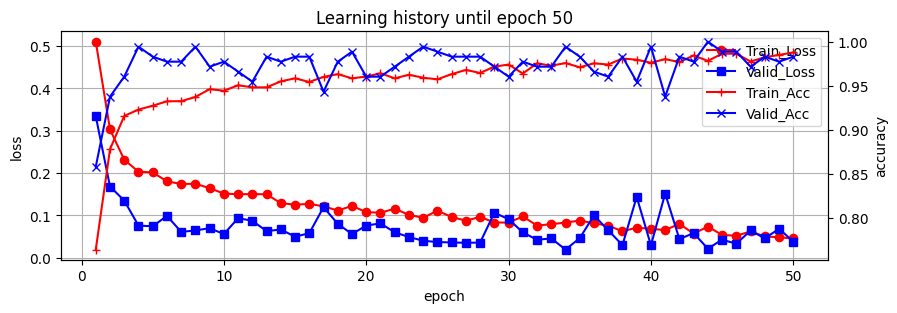

Epoch:  50 | T_Loss 0.045 | T_Acc 0.988 | V_Loss 0.038 | V_Acc 0.983 | 1.544
Epoch:  49 | T_Loss 0.048 | T_Acc 0.985 | V_Loss 0.068 | V_Acc 0.977 | 1.548
Epoch:  48 | T_Loss  0.05 | T_Acc 0.982 | V_Loss 0.046 | V_Acc 0.983 | 1.566
Epoch:  47 | T_Loss 0.062 | T_Acc 0.977 | V_Loss 0.064 | V_Acc 0.972 | 1.563
Epoch:  46 | T_Loss 0.052 | T_Acc 0.986 | V_Loss 0.033 | V_Acc 0.989 | 1.496
Epoch:  45 | T_Loss 0.054 | T_Acc 0.986 | V_Loss 0.043 | V_Acc 0.989 | 1.553
Epoch:  44 | T_Loss 0.073 | T_Acc 0.978 | V_Loss 0.021 | V_Acc   1.0 | 1.643
Epoch:  43 | T_Loss 0.057 | T_Acc 0.984 | V_Loss 0.058 | V_Acc 0.977 | 1.525
Epoch:  42 | T_Loss  0.08 | T_Acc 0.977 | V_Loss 0.044 | V_Acc 0.983 | 1.515
Epoch:  41 | T_Loss 0.065 | T_Acc  0.98 | V_Loss 0.151 | V_Acc 0.938 | 1.585
Epoch:  40 | T_Loss 0.068 | T_Acc 0.976 | V_Loss 0.029 | V_Acc 0.994 | 1.579
Epoch:  39 | T_Loss 0.071 | T_Acc  0.98 | V_Loss 0.144 | V_Acc 0.955 | 1.572
Epoch:  38 | T_Loss 0.062 | T_Acc 0.981 | V_Loss  0.03 | V_Acc 0.983 | 1.532

In [251]:
# Training initialization
init_model()
init_epoch()
init_log()
maximum_epoch = EPOCH

# Training iteration

while epoch_not_finished():
    start_time = time.time()

    tloss, tacc = epoch(train_loader, mode = 'train')

    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)

    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)

    print_log()

print('\n Training completed!')

# 모델 저장하기

model_name = input('Enter the name of the model to be saved. If you don\'t enter it, it won\'t be saved. : ')
if model_name != '':
    model_name = model_name.replace('.pt', '') + '.pt'
    torch.save(net.state_dict(), PT_ROOT + model_name)
    pt_path = PT_ROOT + model_name
    print('Saved.')
else:
    print('Not saved.')

In [12]:
def adjust_bbox(bbox, scale_factor, frame_shape):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    new_width = width * scale_factor
    new_height = height * scale_factor
    
    new_x1 = max(0, int(center_x - new_width / 2))
    new_y1 = max(0, int(center_y - new_height / 2))
    new_x2 = min(int(center_x + new_width / 2), frame_shape[1])
    new_y2 = min(int(center_y + new_height / 2), frame_shape[0])
    
    return [new_x1, new_y1, new_x2, new_y2]

In [ ]:
# test: 영상을 읽어 json 생성
test_root = r'D:\project\New_Data\Video\videos'
trvl_data_root = r'D:\re_landmark\re_landmark'
def test_data_sample(test_root, trvl_data_root, test_num, drive='E'):
    # 기존의 train, valid에서 사용된 데이터를 제외 & 원하는 개수로 N, BY, SY, FY의 비율이 같도록 샘플 추출
    test_root = drive + ':\\' + test_root.split(':\\')[1]
    trvl_data_root = drive + ':\\' + trvl_data_root.split(':\\')[1]
    except_data_list = list(map(lambda x: x.split('\\')[-1].replace('.json', '.mp4'), glob.glob(f'{trvl_data_root}\\*\\*')))
    raw_test_list = list(map(lambda x: x.split('\\')[-1], glob.glob(f'{test_root}\\*')))
    print('raw_test_list_len: ', len(raw_test_list))
    test_list = list(set(raw_test_list) - set(except_data_list))
    print('test_list len: ', len(test_list))
    test_dict = {
        x: random.sample([i for i in test_list if i.split('_')[-2] == x], test_num // 4) 
        for x in cls_filename_list
        }
    print('test_dict length: ', [f'{i}: {len(test_dict[i])}' for i in cls_filename_list])

    return test_dict, test_root


In [15]:
test_dict, test_root = test_data_sample(test_root, trvl_data_root, 120, drive='D')

raw_test_list_len:  9064
test_list len:  8336
test_dict length:  ['N: 30', 'BY: 30', 'FY: 30', 'SY: 30']


In [16]:
def make_test_data(test_dict, test_root):
    # test dataset 채우기
    test_data = {'N': [], 'BY': [], 'SY': [], 'FY': []}
    for cls in cls_filename_list:
        vid_list = test_dict[cls]
        for vid in tqdm(vid_list):
            cap = cv2.VideoCapture(test_root + '\\' + vid)

            frame_count = 0
            frame_err = -1
            frame_err_step = 2
            prev_or_next = 1
            err_count = 0
            result_dict = {
                    'vid_root': test_root + '\\' + vid,
                    'key': 0 if vid.split('_')[-2] == 'N' else 1,
                    'value': []
                    }
            
            while cap.isOpened():

                # 직전에 pose 감지 성공시
                if frame_err == -1: 
                    frame_err_step = 2
                    prev_or_next = 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
                    ret, frame = cap.read()
                    if not ret: break

                # 직전에 pose 감지 실패시: 실패 프레임 위치를 기준으로 +1, -1, +2, -2, +3...순으로 프레임을 읽으며 먼저 성공한 프레임의 값으로 대체
                else:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_err + int(frame_err_step / 2) * prev_or_next)
                    ret, frame = cap.read()
                    if not ret:
                        frame_err_step += 1
                        prev_or_next *= -1
                        break
                # frame = cv2.resize(frame, (1920, 1080))
                results = model(frame, verbose=False)[0]

                # yolo, mediapipe를 활용한 pose x, y, z 데이터 추출
                boxes = results.boxes
                for box in boxes:
                    class_name = model.names[int(box.cls)]

                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    bx1, by1, bx2, by2 = adjust_bbox([x1, y1, x2, y2], scale_factor=1.2, frame_shape=frame.shape)
                    person_image = frame[by1:by2, bx1:bx2]

                    # MediaPipe로 포즈 추정
                    results_pose = pose.process(cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB))
                    
                    pose_xyz_list = []

                    # 감지 성공
                    if results_pose.pose_landmarks:
                        # print(results_pose.pose_landmarks)
                        for idx, landmark in enumerate(results_pose.pose_landmarks.landmark):
                            if idx in DESIRED_LANDMARKS:
                                # 전체 프레임에 대한 상대적 좌표로 변환
                                pose_x = (bx1 + landmark.x * person_image.shape[1]) / frame.shape[1]
                                pose_y = (by1 + landmark.y * person_image.shape[0]) / frame.shape[0]
                                pose_z = landmark.z
                                pose_xyz_list += [pose_x, pose_y, pose_z]
                        result_dict['value'].append(pose_xyz_list)
                        # print(pose_xyz_list)
                        # pose_landmark가 제대로 감지 안된 경우 실패로 처리(if results_pose.pose_landmarks:는 통과하지만 실제로는 값이 없을 수 있음)
                        if pose_xyz_list == []:
                            if frame_err == -1:
                                frame_err = frame_count
                                err_count += 1
                            else:
                                frame_err_step += 1
                                prev_or_next *= -1
                        elif frame_err != -1:
                            # print('fixed')
                            frame_err = -1

                    # 감지 실패
                    else:
                        if frame_err == -1:
                            frame_err = frame_count
                            err_count += 1
                        else:
                            frame_err_step += 1
                            prev_or_next *= -1
                    break

                if frame_err == -1:            
                    frame_count += FRAME_INTERVAL
                    # print('***', frame_count // 24)
                if frame_count >= 600:
                    # print('-----------\n')
                    break
            cap.release()
            if err_count < 13:
                test_data[cls].append(result_dict)
            else: break
    for cls in cls_filename_list:
        print(f'len_of_test_data_{cls}: {len(test_data[cls])}\n')
    return test_data

In [17]:
test_data = {}
test_data = make_test_data(test_dict, test_root)
test_data

100%|██████████| 30/30 [05:37<00:00, 11.26s/it]


len_of_test_data_N: 30

len_of_test_data_BY: 30

len_of_test_data_FY: 30

len_of_test_data_SY: 30



{'N': [{'vid_root': 'D:\\project\\New_Data\\Video\\videos\\01832_Y_A_N_C6.mp4',
   'key': 0,
   'value': [[0.6204862444661557,
     0.4505559260232581,
     -0.4676316976547241,
     0.6350832549234231,
     0.46331000123862864,
     -0.026572545990347862,
     0.6008342281915248,
     0.4603321487566939,
     -0.11627566069364548,
     0.6442297426983714,
     0.46202364838509646,
     -0.699982762336731,
     0.6088382312717537,
     0.4635623270921685,
     -0.9444417357444763,
     0.6218403657277425,
     0.559105627073182,
     0.010368871502578259,
     0.59941338027517,
     0.5546303685340617,
     -0.0096387704834342,
     0.6210624826761584,
     0.6280194669961929,
     -0.13468976318836212,
     0.5913362230174244,
     0.6255038197669718,
     -0.0601675920188427,
     0.6114102667818467,
     0.6868346300941927,
     0.03871084749698639,
     0.5849824058512847,
     0.6885909574175323,
     0.04494638368487358],
    [0.6157269839740669,
     0.5295095257461071,
     -0.

In [18]:
for cls in cls_filename_list:
    print([len(test_data[cls][i]['value']) for i in range(5)])

[25, 25, 25, 25, 25]
[25, 25, 25, 25, 25]
[25, 25, 25, 25, 25]
[25, 25, 25, 25, 25]


In [19]:
test_data_flatten = np.array(list(test_data.values())).flatten().tolist()
test_data_toDataset = list(map(lambda x: {'key': x['key'], 'value': x['value']}, test_data_flatten))

In [20]:
# test_loader 생성
test_dataset = MyDataset(test_data_toDataset)
# train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(test_loader)

In [23]:
# 정확도 검증
with torch.no_grad():
    init_model()
    init_epoch()
    init_log()
    maximum_epoch = EPOCH
    test_loss, test_acc = epoch(test_loader, mode = 'test', pt_path=r'D:\project\CVProject\my_model_pt\GRU.pt')
    print(pt_path)
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [247]:
# test_vid()에서 사용
def draw_line_plot1(pose_xyz_dic, elev, azim, roll, w, h, z_ratio, extent):

    fontlabel = {"fontsize":"large", "color":"gray", "fontweight":"bold"}
    fig, ax = plt.subplots(ncols=1, figsize=(5, 5), subplot_kw={"projection":"3d"})
    ax.view_init(elev=elev, azim = azim, roll=roll)
    ax.set_xlabel('Z', fontdict=fontlabel, labelpad=8)
    ax.set_ylabel('X', fontdict=fontlabel, labelpad=8)
    ax.set_zlabel('Y', fontdict=fontlabel, labelpad=8)
    ax.set_ylim(int(extent['x']['m']*w), int(extent['x']['M']*w))
    ax.set_zlim(int(extent['y']['m']*h), int(extent['y']['M']*h))
    ax.set_xlim(extent['z']['m'], extent['z']['M'])
    ax.set_box_aspect([
        z_ratio,
        extent['x']['M'] - extent['x']['m'], 
        extent['y']['M'] - extent['y']['m'],
        ])
    ax.set_zlim(ax.get_zlim()[::-1])
    ax.set_xlim(ax.get_xlim()[::-1])

    for line in LINE_LIST_MODIFIED:
        lx1, ly1, lz1 = pose_xyz_dic[line[0] * 3 + 0], pose_xyz_dic[line[0] * 3 + 1], pose_xyz_dic[line[0] * 3 + 2]
        lx2, ly2, lz2 = pose_xyz_dic[line[1] * 3 + 0], pose_xyz_dic[line[1] * 3 + 1], pose_xyz_dic[line[1] * 3 + 2]
        lx1, lx2 = lx1 * w, lx2 * w
        ly1, ly2 = ly1 * h, ly2 * h
        ax.plot([lz1, lz2], [lx1, lx2], [ly1, ly2])

    for idx in range(len(DESIRED_LANDMARKS)):
        ax.scatter(pose_xyz_dic[idx * 3 + 2], pose_xyz_dic[idx * 3 + 0]*w, pose_xyz_dic[idx * 3 + 1]*h)
        ax.text(pose_xyz_dic[idx * 3+ 2], pose_xyz_dic[idx * 3 + 0]*w, pose_xyz_dic[idx * 3 + 1]*h, idx)

    fig.canvas.draw()
    img_plot = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    
    return img_plot

In [308]:
# 실제 영상으로 테스트
def test_vid(test_data_flatten=test_data_flatten):
    init_model()
    init_epoch()
    init_log()
    test_data_toDataset = list(map(lambda x: {'key': x['key'], 'value': x['value']}, test_data_flatten))
    test_dataset = MyDataset(test_data_toDataset)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    model = net
    model.load_state_dict(torch.load(r'E:\project\code\my_model_pt\GRU.pt'))
    model.eval()

    correct = 0
    idx = 1
    plt.figure(figsize=(10, len(test_data_flatten)//10 + 10))
    for data, loader in zip(tqdm(test_data_flatten), test_loader):
        loader = loader[0].to(device)
        results = model(loader)
        _, predicted = torch.max(results, 1)
        pred = 'N' if predicted.item() == 0 else 'F'
        root = data['vid_root']
        true_cls = 'N' if root.split('\\')[-1].split('_')[-2] == 'N' else 'F'
        correct += int(pred == true_cls)
        cap = cv2.VideoCapture(root)
        while cap.isOpened():
            _, frame = cap.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (960, 540))
            plt.subplot(len(test_data_flatten)//10 + 10, 10, idx)
            plt.title(f'T: {true_cls[-1]}, P: {pred[0]}')
            plt.axis('off')
            plt.imshow(frame)
            break
        cap.release()
        idx += 1
    plt.tight_layout()
    plt.show()
    acc = correct / (idx) * 100
    print(f'accuracy: {acc:.2f}%')


In [ ]:
# 실제 영상으로 테스트 & pose 시연
# test_root = r'D:\project\New_Data\Video\videos'
def test_and_show_vid(test_data_flatten=test_data_flatten):
    init_model()
    init_epoch()
    init_log()
    test_data_toDataset = list(map(lambda x: {'key': x['key'], 'value': x['value']}, test_data_flatten))
    test_dataset = MyDataset(test_data_toDataset)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    model = net
    model.load_state_dict(torch.load(r'E:\project\code\my_model_pt\GRU.pt'))
    model.eval()
    for data, loader in zip(test_data_flatten, test_loader):
        loader = loader[0].to(device)
        results = model(loader)
        _, predicted = torch.max(results, 1)
        pred = 'Normal' if predicted.item() == 0 else 'Fall'
        
        root = data['vid_root']
        cap = cv2.VideoCapture(root)
        if not cap.isOpened():
            print('Not opened!')
            continue
        
        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        new_h = RES_OF_MONITER[1] // 2
        new_w = int(new_h / h * w)
        angle_elev = 0
        angle_azim = -10
        angle_roll = 0
        extent = {'x': {'m': 9999, 'M': -9999}, 'y': {'m': 9999, 'M': 0}, 'z': {'m': 9999, 'M': -9999}}
        # 최대/최소 x, y, z 값 구하기

        for i, j, k in product(range(25), range(3), range(len(DESIRED_LANDMARKS))):
            xyz = ['x', 'y', 'z']
            temp = data['value'][i][j +3*k]
            extent[xyz[j]]['m']= min(extent[xyz[j]]['m'], temp)
            extent[xyz[j]]['M']= max(extent[xyz[j]]['M'], temp)

        z_ratio = (extent['y']['M'] - extent['y']['m']) / 2

        vid_next = False
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # 프레임 건너뛰기 (예: 매 5번째 프레임만 처리)
            if frame_count % 24 != 0:
                frame_count += 1
                continue
            frame = cv2.resize(frame, (new_w, new_h))
            pose_xyz_dic = data['value'][min(frame_count // 24, 576)]

            img_plot = draw_line_plot1(pose_xyz_dic, angle_elev, angle_azim, angle_roll, new_w, new_h, z_ratio, extent)

            cv2.putText(frame, f'{root.split(bs)[-1]}: {str(frame_count)}f', (10, 30), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
            cv2.putText(frame, f'True: {"Normal" if root.split(bs)[-1].split("_")[-2] == "N" else "Fall"}, Pred: {pred}', 
                        (10, 60), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
            img_plot = cv2.putText(img_plot, f'azim: {angle_azim}, elev: {angle_elev}, roll: {angle_roll}', 
                                (10, 60), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
            cv2.imshow('image. press q to quit, p to pause, n to pass', frame)
            cv2.imshow('plot', img_plot)
            if frame_count == 0: cv2.waitKey(40)
            key = cv2.waitKey(5) & 0xFF
            if key == ord('q'):
                cv2.destroyAllWindows()
                cap.release()
                return 0
            if key == ord('n'):
                vid_next = True
                cv2.destroyAllWindows()
                cap.release()
                break
            if key == ord('p'):
                while True:
                    frame = cv2.putText(frame, 'Paused. Use ASD & ZXC to change the angle of plot.', (10, 90), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
                    frame = cv2.putText(frame, 'A/S/D: +5 on azim/elev/roll, Z/X/C: -5 on\"\" \"\"', (10, 120), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
                    frame = cv2.putText(frame, 'F/V to lengthen/shorten the z-axis.', (10, 150), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
                    frame = cv2.putText(frame, 'Press p again to resume.', (10,180), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
                    cv2.imshow('image. press q to quit, p to pause, n to pass', frame)
                    key = cv2.waitKey() & 0xFF

                    if key == ord('a'):
                        angle_azim += 5
                    elif key == ord('s'):
                        angle_elev += 5
                    elif key == ord('d'):
                        angle_roll += 5
                    elif key == ord('z'):
                        angle_azim -= 5
                    elif key == ord('x'):
                        angle_elev -= 5
                    elif key == ord('c'):
                        angle_roll -= 5
                    elif key == ord('f'):
                        z_ratio += (extent['z']['M'] - extent['z']['m'])*0.02
                    elif key == ord('v'):
                        z_ratio = max(z_ratio - (extent['z']['M'] - extent['z']['m'])*0.02, 0.1)
                    elif key == ord('n'):
                        vid_next = True
                        cv2.destroyAllWindows()
                        cap.release()
                        break
                    elif key == ord('p'):
                        break
                    elif key == ord('q'):
                        cv2.destroyAllWindows()
                        cap.release()
                        return 0
                    else:
                        continue
                    
                    img_plot = draw_line_plot1(pose_xyz_dic, angle_elev, angle_azim, angle_roll, new_w, new_h, z_ratio, extent)
                    img_plot = cv2.putText(img_plot, f'azim: {angle_azim}, elev: {angle_elev}, roll: {angle_roll}', (10, 60), cv2.FONT_HERSHEY_DUPLEX, 1, COLOR_PINK, 1, lineType=cv2.LINE_AA)
                    cv2.imshow('plot', img_plot)
                if vid_next == True: 
                    break
            frame_count += 1
            if frame_count > 576: break
            
            
        cap.release()
    return 0

In [309]:
test_vid(test_data_flatten)

100%|██████████| 120/120 [00:24<00:00,  4.92it/s]


accuracy: 93.39%


In [270]:
test_and_show_vid(test_data_flatten)

0